
📌 Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None

📌 Statistical Summary:
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


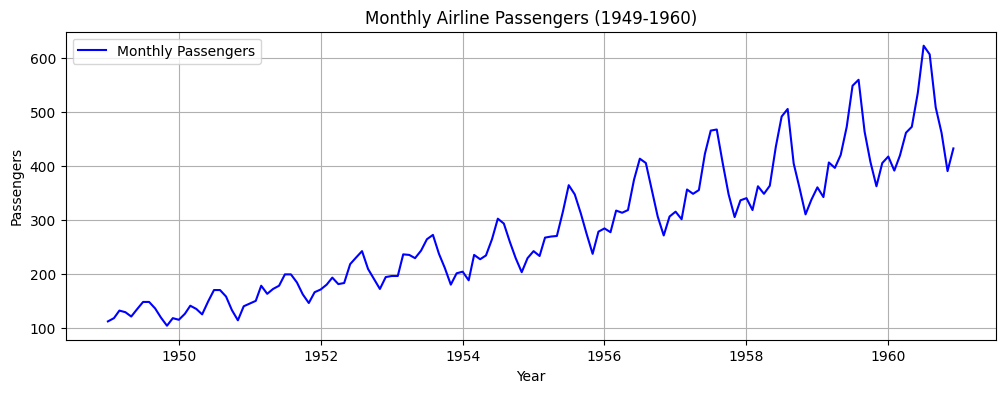

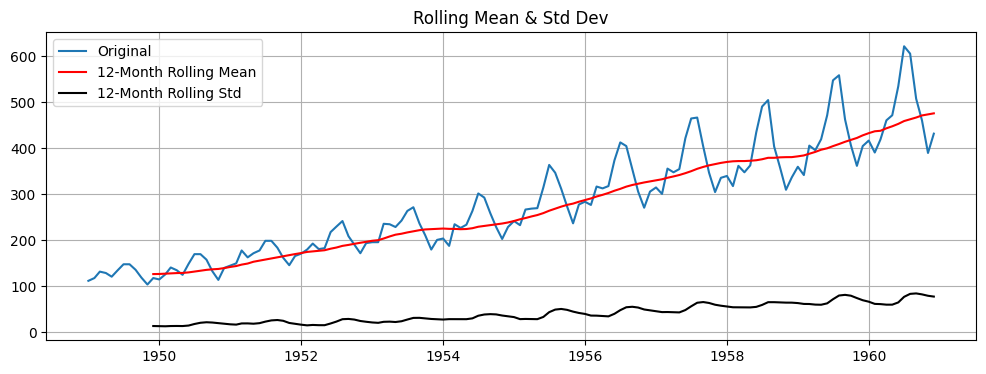

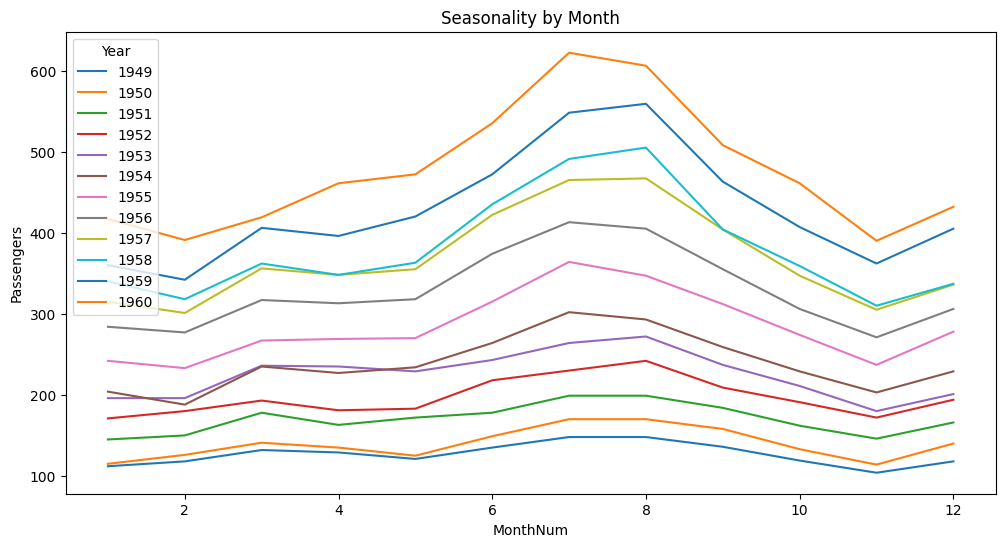

c:\python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

✅ RMSE (Standard LSTM): 68.50
✅ RMSE (Bidirectional LSTM): 68.21


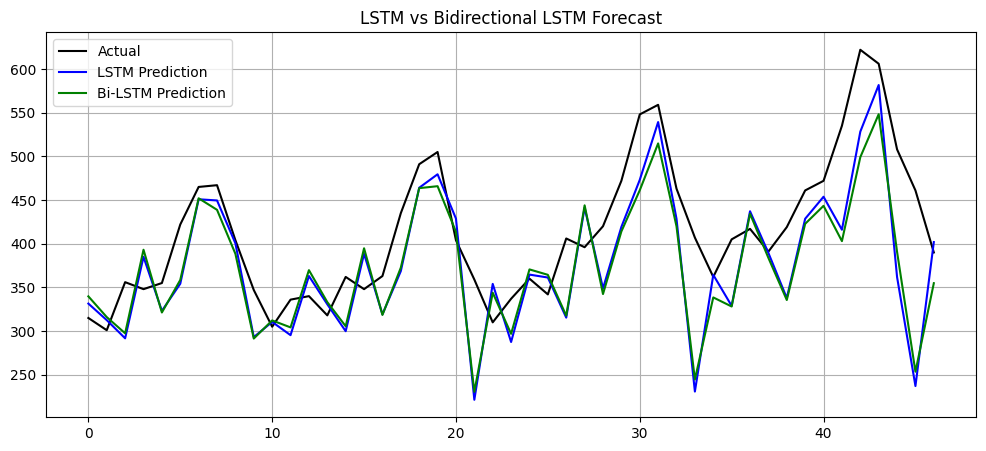

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.columns = ['Passengers']

# ---------------------
# 📊 EDA
# ---------------------
print("\n📌 Data Info:")
print(df.info())

print("\n📌 Statistical Summary:")
print(df.describe())

# Time series plot
plt.figure(figsize=(12, 4))
plt.plot(df, label='Monthly Passengers', color='blue')
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.show()

# Rolling stats
rolling_mean = df['Passengers'].rolling(window=12).mean()
rolling_std = df['Passengers'].rolling(window=12).std()

plt.figure(figsize=(12, 4))
plt.plot(df['Passengers'], label='Original')
plt.plot(rolling_mean, label='12-Month Rolling Mean', color='red')
plt.plot(rolling_std, label='12-Month Rolling Std', color='black')
plt.title('Rolling Mean & Std Dev')
plt.legend()
plt.grid(True)
plt.show()

# Seasonal plot
df_seasonal = df.copy()
df_seasonal.reset_index(inplace=True)
df_seasonal['Year'] = df_seasonal['Month'].dt.year
df_seasonal['MonthNum'] = df_seasonal['Month'].dt.month

pivot = df_seasonal.pivot_table(values='Passengers', index='MonthNum', columns='Year')
pivot.plot(figsize=(12, 6), title='Seasonality by Month')
plt.ylabel('Passengers')
plt.show()

# Clean up temporary columns
df.drop(columns=['Passengers'], inplace=True)
df = df_seasonal.set_index('Month')[['Passengers']]

# ---------------------
# 🔧 Preprocessing
# ---------------------
data = df.values.astype('float32')

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Supervised format
def create_dataset(dataset, look_back=3):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], look_back, 1))

# ---------------------
# 📂 Train-test split
# ---------------------
train_size = int(len(X) * 0.67)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ---------------------
# 🧠 Model 1: Stacked LSTM
# ---------------------
model1 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
])
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

# ---------------------
# 🔁 Model 2: Bidirectional LSTM
# ---------------------
model2 = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, 1)),
    Bidirectional(LSTM(50)),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

# ---------------------
# 📈 Evaluation
# ---------------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse scaling
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_inv = scaler.inverse_transform([y_train])
    y_test_inv = scaler.inverse_transform([y_test])

    rmse = sqrt(mean_squared_error(y_test_inv[0], test_pred[:, 0]))
    return test_pred, y_test_inv, rmse

test_pred1, y_test_inv1, rmse1 = evaluate_model(model1, X_train, X_test, y_train, y_test)
test_pred2, y_test_inv2, rmse2 = evaluate_model(model2, X_train, X_test, y_train, y_test)

print(f"\n✅ RMSE (Standard LSTM): {rmse1:.2f}")
print(f"✅ RMSE (Bidirectional LSTM): {rmse2:.2f}")

# ---------------------
# 📉 Plot Comparison
# ---------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv1[0], label='Actual', color='black')
plt.plot(test_pred1, label='LSTM Prediction', color='blue')
plt.plot(test_pred2, label='Bi-LSTM Prediction', color='green')
plt.title('LSTM vs Bidirectional LSTM Forecast')
plt.legend()
plt.grid(True)
plt.show()
